In [1]:
import pandas as pd
import librosa
import os
import numpy as np
import re
from pydub import AudioSegment


In [2]:
df = pd.read_csv('./data/results_wav.csv', sep=';')

df.head()

,title,region,keyword,duration,url,path,wav_path
0,Bungong Jeumpa | Lirik dan Terjemahan | Lagu D...,Aceh,Bungong Jeumpa asal Aceh,4.03,https://www.youtube.com/watch?v=lAVi2OE2bRY&pp...,datasets/songs/bungong_jeumpa_lirik_dan_terjem...,datasets/wav_songs/bungong_jeumpa_lirik_dan_te...
1,Bungong Jeumpa - Putri Ariani Cover (Lagu Daer...,Aceh,Bungong Jeumpa asal Aceh,2.40,https://www.youtube.com/watch?v=RjI7W_XmzLM&pp...,datasets/songs/bungong_jeumpa_putri_ariani_cov...,datasets/wav_songs/bungong_jeumpa_putri_ariani...
2,Tari Bungong Jeumpa Aceh |Rumah Belajar Mawinsya,Aceh,Bungong Jeumpa asal Aceh,3.30,https://www.youtube.com/watch?v=W3PRdCxocM0&pp...,datasets/songs/tari_bungong_jeumpa_aceh_rumah_...,datasets/wav_songs/tari_bungong_jeumpa_aceh_ru...
3,Jambo - Safira Amalia (Official Music Video),Aceh,Jambo – Jambo asal Aceh,4.14,https://www.youtube.com/watch?v=-biMic3z6wo&pp...,datasets/songs/jambo_safira_amalia_official_mu...,datasets/wav_songs/jambo_safira_amalia_officia...
4,TARIAN ACEH JAMBO JAMBO,Aceh,Jambo – Jambo asal Aceh,4.18,https://www.youtube.com/watch?v=UStY_f5c6Oo&pp...,datasets/songs/tarian_aceh_jambo_jambo.mp3,datasets/wav_songs/tarian_aceh_jambo_jambo.wav


In [5]:
def get_duration(file_path):
    if pd.isna(file_path):  # Menangani NaN atau None
        print('Skipping: file path is NaN or None')
        return None, None
    
    y, sr = librosa.load(file_path)
    duration = librosa.get_duration(y=y, sr=sr)
    print(f'sample rate: {sr}, duration: {duration}')
    return sr, duration

In [6]:
df['sample_rate'], df['duration_sec'] = zip(*df['wav_path'].map(get_duration))


sample rate: 22050, duration: 242.13768707482993
sample rate: 22050, duration: 159.79972789115646
sample rate: 22050, duration: 209.62975056689342
sample rate: 22050, duration: 253.60834467120182
sample rate: 22050, duration: 257.5092970521542
sample rate: 22050, duration: 148.21297052154196
sample rate: 22050, duration: 254.44426303854874
sample rate: 22050, duration: 179.67600907029478
sample rate: 22050, duration: 153.83219954648527
sample rate: 22050, duration: 151.3012244897959
sample rate: 22050, duration: 173.17442176870748
sample rate: 22050, duration: 295.0095238095238
sample rate: 22050, duration: 150.14022675736962
sample rate: 22050, duration: 239.09587301587302
sample rate: 22050, duration: 284.97850340136057
sample rate: 22050, duration: 140.57360544217687
sample rate: 22050, duration: 284.1425850340136
sample rate: 22050, duration: 254.46748299319728
sample rate: 22050, duration: 296.10086167800455
sample rate: 22050, duration: 243.73986394557824
sample rate: 22050, dura

In [7]:
df.describe()

,duration,sample_rate,duration_sec
count,856.000000,854.0,854.000000
mean,3.259953,22050.0,207.840193
std,1.044537,0.0,62.439614
min,0.000000,22050.0,8.196644
25%,2.450000,22050.0,165.860136
50%,3.400000,22050.0,219.904580
75%,4.160000,22050.0,255.831655
max,5.000000,22050.0,299.514195


In [ ]:
# import matplotlib.pyplot as plt

# for index, row in df.iterrows():
#     y, sr = librosa.load(row['wav_path'])
#     plt.figure(figsize=(10, 4))
#     librosa.display.waveshow(y, sr=sr)
#     plt.title(f"Waveform of {row['title']}")
#     plt.xlabel("Time (s)")
#     plt.ylabel("Amplitude")
#     plt.show()

In [19]:
def sanitize_filename(filename):
    """
    Removes or replaces invalid characters from a filename or folder name.
    """
    return re.sub(r'[<>:"/\\|?*]', '', filename)

def normalized_yt_title(title):
    text = title.lower()
    text = text.replace(' ', '_')
    text = re.sub(r'[^a-z0-9_]', '', text)
    text = re.sub(r'_{2,}', '_', text)
    
    return text

split_result = []

def split_songs_to_segments(df, output_base_folder='datasets/30s_segments'):
    for index, row in df.iterrows():
        wav_path = row['wav_path']
        title = row['title']
        region = row['region']
        keyword = row['keyword']
        
        # Cek jika wav_path adalah string dan file yang valid
        if isinstance(wav_path, str) and os.path.isfile(wav_path):
            norm_title = normalized_yt_title(title)
            norm_region = region.lower().replace(' ', '_')
            output_dir = os.path.join(output_base_folder, norm_region)
            
            audio = AudioSegment.from_wav(wav_path)
            total_duration = len(audio) / 1000  # Durasi dalam detik
            segment_duration = 30
            num_segments = int(total_duration // segment_duration)


            os.makedirs(output_dir, exist_ok=True)

            for i in range(num_segments):
                start_time = i * segment_duration * 1000
                end_time = (i + 1) * segment_duration * 1000
                segment = audio[start_time:end_time]
                
                segment_file = os.path.join(output_dir, f"segment{i + 1}.wav")
                segment.export(segment_file, format="wav")
                
                split_result.append({
                    'title': title,
                    'region': region,
                    'keyword': keyword,
                    '30s_path': segment_file
                })
            print(f"Saved {num_segments} segments in {norm_region} for {title} at: {output_dir}")
        else:
            print(f"Invalid wav_path at index {index}: {wav_path}")


In [20]:
split_songs_to_segments(df)

Saved 8 segments in aceh for Bungong Jeumpa | Lirik dan Terjemahan | Lagu Daerah Aceh | Dongeng Kita at: datasets/30s_segments\aceh
Saved 5 segments in aceh for Bungong Jeumpa - Putri Ariani Cover (Lagu Daerah Aceh) at: datasets/30s_segments\aceh
Saved 6 segments in aceh for Tari Bungong Jeumpa Aceh |Rumah Belajar Mawinsya at: datasets/30s_segments\aceh
Saved 8 segments in aceh for Jambo - Safira Amalia (Official Music Video) at: datasets/30s_segments\aceh
Saved 8 segments in aceh for TARIAN ACEH JAMBO JAMBO at: datasets/30s_segments\aceh
Saved 4 segments in aceh for Lembah Alas - Lagu Daerah Aceh (dengan Lirik) at: datasets/30s_segments\aceh
Saved 8 segments in aceh for LEMBAH ALAS - LAGU DAERAH ACEH - Enjoy Pesona Musik Indonesia at: datasets/30s_segments\aceh
Saved 5 segments in aceh for Aceh Lon Sayang - Lagu Daerah Aceh (Lirik dan Terjemahan) at: datasets/30s_segments\aceh
Saved 5 segments in aceh for Lagu Aceh Lon Sayang - Lagu Daerah Aceh at: datasets/30s_segments\aceh
Saved 5 s

In [25]:
df_res = pd.DataFrame(split_result)

### Noice Reduce

In [ ]:
# Noice Reduce

In [34]:
def extract_mfcc_features(wav_path, n_mfcc=13):
    y, sr = librosa.load(wav_path)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

In [35]:
df_res['mfcc_features'] = df_res['30s_path'].apply(extract_mfcc_features)
df_res.head()

,title,region,keyword,30s_path,mfcc_features
0,KICIR KICIR - Lagu dan Tari Nusantara - Lagu Anak,Jakarta,Kicir-Kicir asal Jakarta,datasets/30s_segments/jakarta/kicir_kicir_lagu...,"[-161.10701, 88.2896, -4.8944087, 21.922462, -..."
1,KICIR KICIR - Lagu dan Tari Nusantara - Lagu Anak,Jakarta,Kicir-Kicir asal Jakarta,datasets/30s_segments/jakarta/kicir_kicir_lagu...,"[-83.09855, 94.346504, -21.865372, 32.208786, ..."
2,KICIR KICIR - Lagu dan Tari Nusantara - Lagu Anak,Jakarta,Kicir-Kicir asal Jakarta,datasets/30s_segments/jakarta/kicir_kicir_lagu...,"[-89.93492, 92.994514, -17.861044, 36.76891, -..."
3,KICIR KICIR - Lagu dan Tari Nusantara - Lagu Anak,Jakarta,Kicir-Kicir asal Jakarta,datasets/30s_segments/jakarta/kicir_kicir_lagu...,"[-97.85396, 97.05946, -6.5225873, 33.598427, -..."
4,KICIR KICIR - Lagu dan Tari Nusantara - Lagu Anak,Jakarta,Kicir-Kicir asal Jakarta,datasets/30s_segments/jakarta/kicir_kicir_lagu...,"[-88.59536, 93.96856, -18.004303, 34.058342, -..."


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Prepare the data
X = np.array(df_res['mfcc_features'].tolist())
y = df_res['keyword']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.92


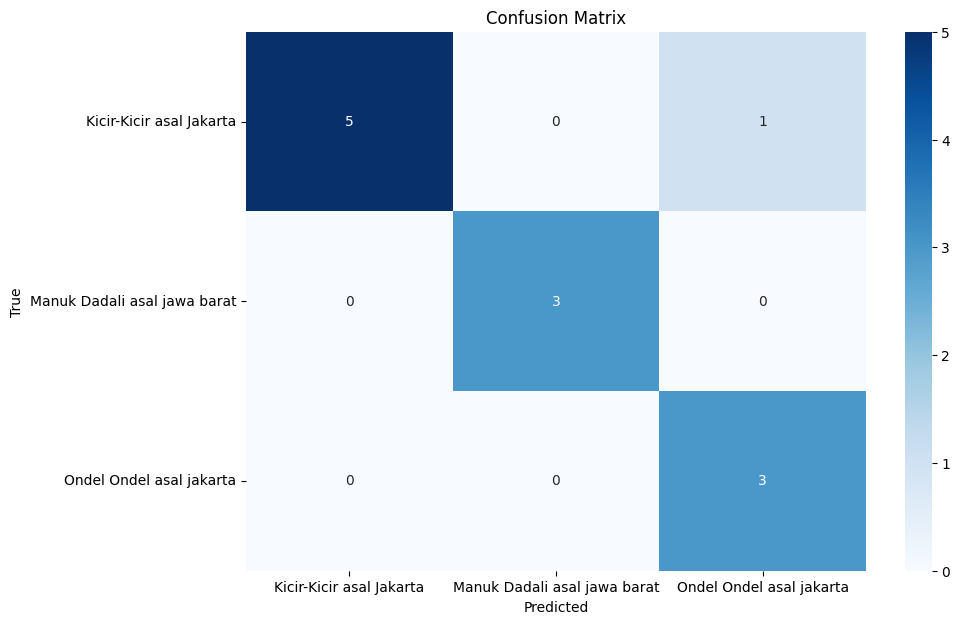

                              precision    recall  f1-score   support

    Kicir-Kicir asal Jakarta       1.00      0.83      0.91         6
Manuk Dadali asal jawa barat       1.00      1.00      1.00         3
    Ondel Ondel asal jakarta       0.75      1.00      0.86         3

                    accuracy                           0.92        12
                   macro avg       0.92      0.94      0.92        12
                weighted avg       0.94      0.92      0.92        12



In [51]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=model.classes_))